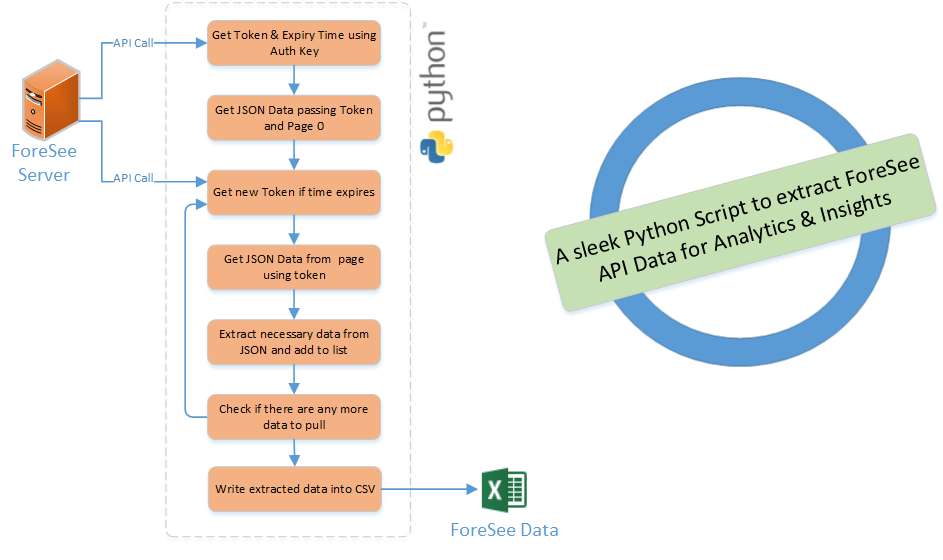

In [ ]:
##################################################################################
# Author: Rajkumar Rajendran
##################################################################################

import requests, datetime, pytz, time, pandas

##################################################################################
# Attention: Please update Auth key for Forsee API below

auth_key = '<your auth key>'

##################################################################################
# General Process flow of the script is below
# 1. Using Auth key for Forsee API, get token and expiry time
# 2. Using Token and page number, get data in JSON format
# 3. From retrieved JSON data, get content for needed key words as rows 
# 4. Get all the rows and Output the data as CSV file
##################################################################################

##################################################################################
# All Functions are defined below
##################################################################################
# function to get start time, access token and expiry_time in seconds
def get_access_token():
    request = requests.post(url=token_url, params=token_params, headers=token_headers)
    if request.status_code != 200:
        print("couldn't complete access token request")
        request.raise_for_status()
        quit()
    else:
        token_data = request.json()
        token = token_data.get('access_token')
        expiry = token_data.get('expires_in')
        return time.time(), token, expiry


# Function to get data using the access token retrieved from previous call
def get_data(token, offset):
    # url, params and headers used to get data from API
    data_url = "https://api.foresee.com/v1/measures/9999999/data"
    data_params = {"from": yesterday, "to": yesterday, "limit": "100", 'offset': str(offset)}
    data_headers = {'accept': 'application/json',
                    'authorization': "Bearer " + token}
    request = requests.get(url=data_url, params=data_params, headers=data_headers)
    if request.status_code != 200:
        print("couldn't complete get data request")
        request.raise_for_status()
        quit()
    else:
        return request.json()


# Function to retrieve rows from the json output data, returns all rows as a list
def extract_rows(data):
    out_list = []  # List to be returned with all rows
    for item in data.get('items'):
        id = item.get('id')
        response_time = item.get('responseTime')
        row_list = [id, response_time]  # start row list with ID and response time
        dict = {}  # dictionary to capture data from latentscores and responses
        for latentscores in item.get('latentScores'):
            if latentscores.get('name') in latent_names:  # if name is in our list, get scores
                dict[latentscores.get('name')] = latentscores.get('score')  # add to dictionary
        for responses in item.get('responses'):
            if responses.get('name') in response_names:  # if name is in our list, get answers
                # answers are a list, so use join to remove list and get string
                dict[responses.get('name')] = ','.join(str(x) for x in responses.get('answers'))
        for x in latent_names:
            row_list.append(dict.get(x))  # add latent scores from dictionary to row list
        for y in response_names:
            row_list.append(dict.get(y))  # add responses answers from dictionary to row list
        out_list.append(row_list)  # add row_list to out_list
    return out_list  # return out_list that has all the row_list
##################################################################################

##################################################################################
# Main program flow
##################################################################################
# url, params and headers used to get access token
token_url = 'https://api.foresee.com/v1/token'
token_params = {"grant_type": "client_credentials", "scope": "r_basic"}
token_headers = {"content-type": "application/json",
                 "authorization": auth_key}

# columns for output file and lists to be used to extract scores and answers from latentnames and responsenames
id_response_time = ['Respondentid', 'ResponseTime']
latent_names = ['Product Descriptions', 'Site Performance ', 'Return', 'Purchase From a Vendor',
                'Satisfaction', 'Purchase Online', 'Merchandise', 'Primary Resource', 'Functionality',
                'Product Browsing', 'Navigation', 'Product Images', 'Recommend']
response_names = ['BigBusiness', 'Division', 'Region', 'Business', 'EWCDLocale']

# get access token data along with start time and expires_in values
start_time, access_token, expires_in = get_access_token()

print('Access_Token :', access_token)
print('Expires_In :', expires_in)

# get yesterday's date using current time in CST
yesterday = (datetime.datetime.now(tz=pytz.timezone('America/Chicago')) - datetime.timedelta(days=1)).strftime('%Y-%m-%d')
print(yesterday, 'CST')

data_list = []  # list to consolidate all rows to be written to output csv file
# if time from when token was retrieved exceeds expiry time of access token, retrieve access token again
if (time.time() - start_time) > expires_in:
    start_time, access_token, expires_in = get_access_token()
page_no = 0
# get data using the access token and page number(0-default value for offset param)
data = get_data(access_token, page_no)
data_list += extract_rows(data)  # add rows extracted to data_list

print(data.get('hasMore'))

# if 'hasmore' is True, keep retrieving the data by incrementing page no, until 'hasmore' is not True
while data.get('hasMore') == True:
    print('repeat get data')
    page_no += 1
    if (time.time() - start_time) > expires_in:  # if access token expires, retrieve new access token
        start_time, access_token, expires_in = get_access_token()
    data = get_data(access_token, page_no)  # get data
    data_list += extract_rows(data)  # append rows extracted to data_list
    print(data.get('hasMore'))

# create out_file dataframe with column values
out_file = pandas.DataFrame(data_list, columns=id_response_time + latent_names + response_names)
# write dataframe to csv file
out_file.to_csv('data_list-' + yesterday + '.csv', index=False)
##################################################################################